Ce notebook est le dernier du processus de traitement des données.
Il permet de réaliser différentes analyses statistiques sur les données du corpus, préalablement automomatiquement annotées, ainsi que sur les données du coprus témoin. Le notebook comprend diverses analyses comme le calcul de moyennes, ou encore la production de nombreuses figures, tableaux et graphiques.

Ce notebook a été produit dans Google colab.

In [2]:
import pandas as pd

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import UnivariateSpline
from scipy.signal import medfilt

On commence par renseigner puis importer les chemins des deux fichiers csv :

In [1]:
mon_fichier_path = '/content/annos_emo_expert_vdef.csv'
mon_fichier_temoin_path = '/content/fichier_complet_temoin.csv'

In [3]:
mon_fichier = pd.read_csv(mon_fichier_path, on_bad_lines='skip')
mon_fichier_temoin = pd.read_csv(mon_fichier_temoin_path, on_bad_lines='skip')

mon_fichier

,Unnamed: 0,title,content,score,score_echelle,score_par_label,sum_without_neutral,sum_recalibree,label_dominant,intensite_emotion,score_vf,expertise_gpt4
0,0,climat_corona_et_caetera_henri_de_lesquen.txt,Je suis fier d'être à la tête d'un grand mouve...,0.407600,1,"sad: 0.3099, fear: 0.0083, anger: 0.4076, neut...",0.9238,8.679721,anger,2,2,3.0
1,1,climat_corona_et_caetera_henri_de_lesquen.txt,"Le 26 février 2020, le PSG a joué au pied à Ly...",0.684093,2,"sad: 0.1762, fear: 0.0697, anger: 0.6841, neut...",0.9687,7.345752,anger,2,3,3.0
2,2,climat_corona_et_caetera_henri_de_lesquen.txt,"Le soir même, jeudi 12 mars, sans plus attendr...",0.551490,2,"sad: 0.4262, fear: 0.0081, anger: 0.5515, neut...",0.9901,5.284120,anger,2,3,3.0
3,3,climat_corona_et_caetera_henri_de_lesquen.txt,"En 2004, c'est encore mieux. De plus en plus f...",0.913224,3,"sad: 0.0692, fear: 0.0097, anger: 0.9132, neut...",0.9981,4.022855,anger,2,2,3.0
4,4,climat_corona_et_caetera_henri_de_lesquen.txt,Passons sur le fait que ces statistiques sont ...,0.767427,3,"sad: 0.2059, fear: 0.0092, anger: 0.7674, neut...",0.9894,4.534043,anger,2,2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2394,2394,yves_roucaute_sur_cnews_raphael_dragonneau.txt,"Voici le texte corrigé :\n\n""Par exemple, ils ...",0.961186,1,"sad: 0.0100, fear: 0.0040, anger: 0.0096, neut...",0.0387,0.670930,neutral,1,1,3.0
2395,2395,yves_roucaute_sur_cnews_raphael_dragonneau.txt,"Je veux dire, je vais vous donner deux ou troi...",0.812702,3,"sad: 0.8127, fear: 0.0023, anger: 0.1539, neut...",0.9707,6.449467,sad,2,2,3.0
2396,2396,yves_roucaute_sur_cnews_raphael_dragonneau.txt,"Et bien avant la dernière glaciation, donc il ...",0.619478,1,"sad: 0.2568, fear: 0.0122, anger: 0.0317, neut...",0.3805,4.555210,neutral,1,1,3.0
2397,2397,yves_roucaute_sur_cnews_raphael_dragonneau.txt,"C'est absolument incroyable, c'est fascinant c...",0.743721,2,"sad: 0.0263, fear: 0.0498, anger: 0.0366, neut...",0.9264,28.496339,surprise,3,3,3.0


On effectue d'abord une première étape de nettoyager, pour supprimer les cases vides, et passer toutes les valeurs numériques au même format int.

In [10]:
# les colonnes qui contiennent un NaN ou une valeur non entière sont supprimées :
mon_fichier = mon_fichier.replace([float('inf'), float('-inf')], float('nan')).dropna(subset=['expertise_gpt4'])

# On convertit tout en int, et les colonnes pour lesquelles la conversion est manquée sont supprimées :
mon_fichier['score_vf'] = pd.to_numeric(mon_fichier['score_vf'], errors='coerce')
mon_fichier = mon_fichier.dropna(subset=['score_vf']) # Drop rows where conversion failed
mon_fichier['expertise_gpt4'] = mon_fichier['expertise_gpt4'].astype(int)
mon_fichier['score_vf'] = mon_fichier['score_vf'].astype(int)

**1. Calcul des moyennes**

D'abord pour le corpus principal :

In [12]:
moyenne_emo = mon_fichier['score_vf'].mean()
moyenne_exp = mon_fichier['expertise_gpt4'].mean()
print("la moyenne de l'émotion est : ", moyenne_emo)
print("la moyenne de l'expertise est : ", moyenne_exp)

la moyenne de l'émotion est :  1.7944120100083403
la moyenne de l'expertise est :  2.2789824854045038


Ensuite pour le corpus témoin :

In [13]:
moyenne_emo = mon_fichier_temoin['score_vf'].mean()
moyenne_exp = mon_fichier_temoin['expertise_gpt4'].mean()
print("la moyenne de l'émotion est : ", moyenne_emo)
print("la moyenne de l'expertise est : ", moyenne_exp)

la moyenne de l'émotion est :  1.4437052200614124
la moyenne de l'expertise est :  2.097022587268994


**2. Répartition des données  :**

Pour le corpus principal :

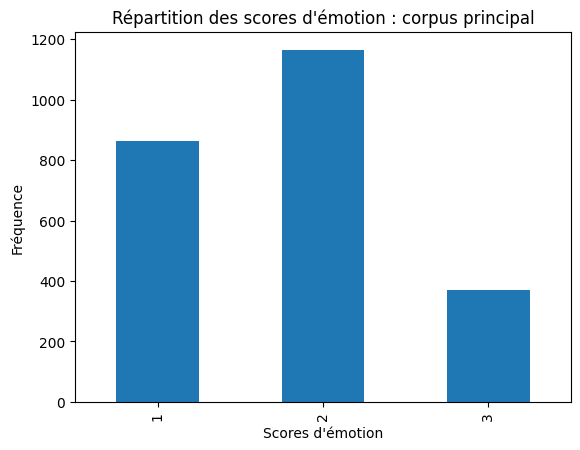

In [20]:
mon_fichier['score_vf'].value_counts().sort_index().plot(
    kind="bar"
)

plt.xlabel("Scores d'émotion")
plt.ylabel("Fréquence")
plt.title("Répartition des scores d'émotion : corpus principal")
plt.show()

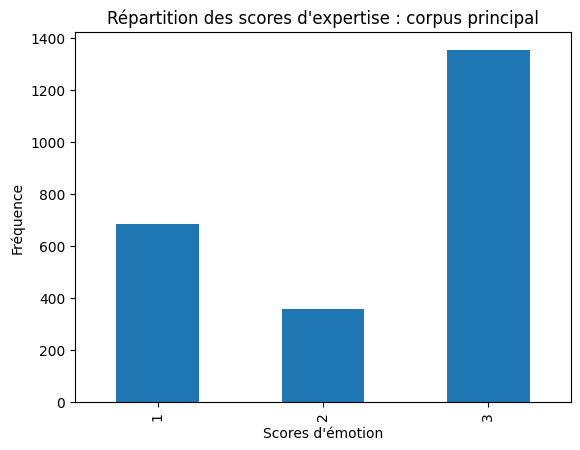

In [21]:
mon_fichier['expertise_gpt4'].value_counts().sort_index().plot(
    kind="bar"
)

plt.xlabel("Scores d'émotion")
plt.ylabel("Fréquence")
plt.title("Répartition des scores d'expertise : corpus principal")
plt.show()

A présent, on peut produire des diagrammes de répartition pour le corpus témoin :

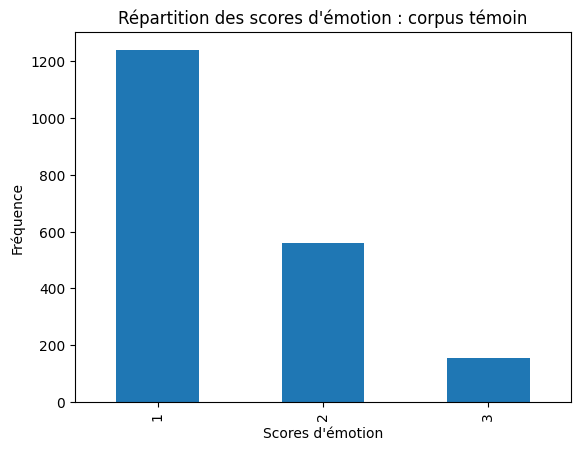

In [22]:
mon_fichier_temoin['score_vf'].value_counts().sort_index().plot(
    kind="bar"
)

plt.xlabel("Scores d'émotion")
plt.ylabel("Fréquence")
plt.title("Répartition des scores d'émotion : corpus témoin")
plt.show()

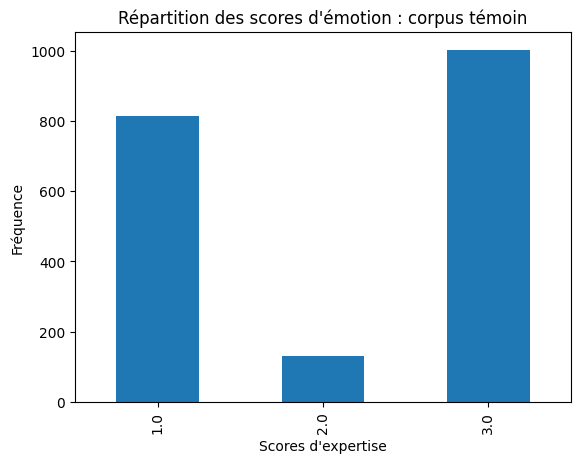

In [23]:
mon_fichier_temoin['expertise_gpt4'].value_counts().sort_index().plot(
    kind="bar"
)

plt.xlabel("Scores d'expertise")
plt.ylabel("Fréquence")
plt.title("Répartition des scores d'émotion : corpus témoin")
plt.show()

**3. Production des courbes émotionnelles en un graphique :**

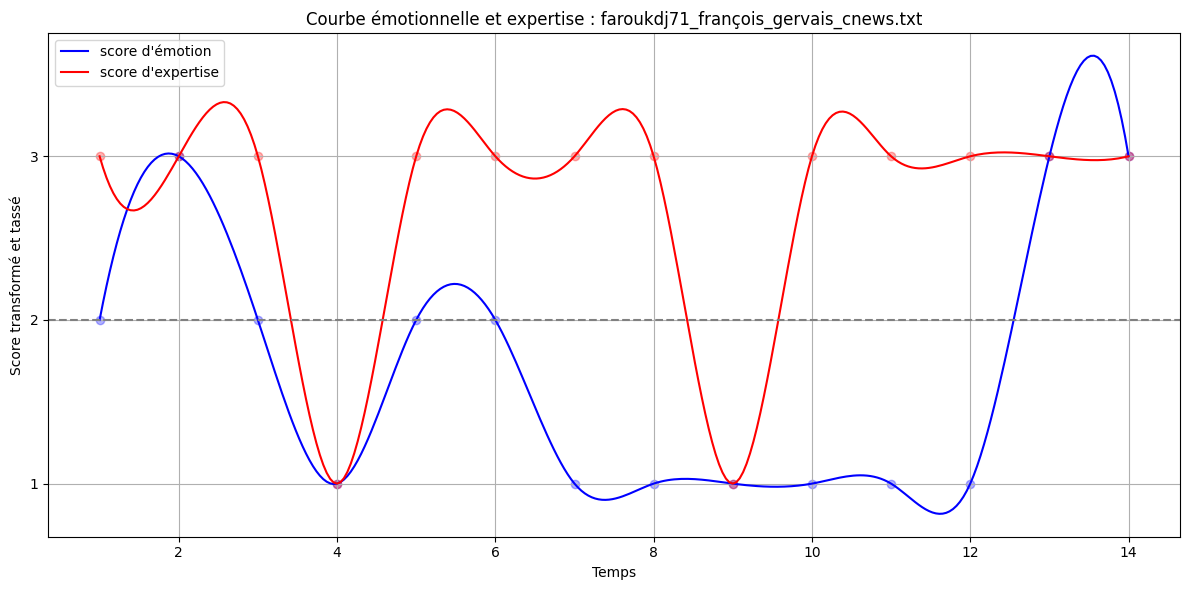

In [44]:
df_filtered = mon_fichier.replace([float('inf'), float('-inf')], np.nan)
df_filtered = df_filtered.dropna(subset=['score_vf', 'expertise_gpt4']).copy()

# --- Conversion 'score_vf' en numérique ---
df_filtered['score_vf'] = pd.to_numeric(df_filtered['score_vf'], errors='coerce')

# --- Filtre sur un titre précis ---
titre_exact = "faroukdj71_françois_gervais_cnews.txt" #remplacer par un titre exact (dans la colonne 'title') :
df_filtered = mon_fichier[mon_fichier['title'] == titre_exact]

# --- Suppression des NaN restants après conversion ---
df_filtered = df_filtered.dropna(subset=['score_vf'])

# --- Conversion en entier ---
df_filtered['score_vf'] = df_filtered['score_vf'].astype(int)

# --- Courbe 1 : score_vf (discret, compressé) ---
score_mapping = {1: -0.2, 2: 0.0, 3: 0.2}
y1 = np.array([score_mapping[s] for s in df_filtered['score_vf']])

# --- Courbe 2 : expertise_gpt4 (normalisation min-max entre -0.2 et 0.2) ---
y2_raw = df_filtered['expertise_gpt4'].values.astype(float)
y2_min, y2_max = y2_raw.min(), y2_raw.max()
y2 = -0.2 + 0.4 * (y2_raw - y2_min) / (y2_max - y2_min)

# --- Axe X ---
x = np.arange(1, len(df_filtered) + 1)

# --- Lissage ---
x_smooth = np.linspace(x.min(), x.max(), 300)
spline1 = make_interp_spline(x, y1, k=3)
spline2 = make_interp_spline(x, y2, k=3)
y1_smooth = spline1(x_smooth)
y2_smooth = spline2(x_smooth)

# --- Tracé ---
plt.figure(figsize=(12, 6))

# Courbe 1 : émotion
plt.plot(x_smooth, y1_smooth, label="score d'émotion", color='blue')
plt.scatter(x, y1, color='blue', alpha=0.3)

# Courbe 2 : expertise
plt.plot(x_smooth, y2_smooth, label="score d'expertise", color='red')
plt.scatter(x, y2, color='red', alpha=0.3)

# Décorations
plt.axhline(0, color='gray', linestyle='--')
plt.title(f"Courbe émotionnelle et expertise : {titre_exact}")
plt.xlabel("Temps")
plt.ylabel("Score transformé et tassé")
plt.yticks(ticks=[-0.2, 0.0, 0.2], labels=['1', '2', '3'])

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**4. quelle est la longueur moyenne des palliers pour chaque score pour l'émotion et pour l'expertise ?**

In [52]:
def get_runs(df, col):
    # Créer un groupe qui change chaque fois que la valeur de la colonne change
    group_id = (df[col] != df[col].shift()).cumsum()

    # Grouper par ces segments
    runs = df.groupby(group_id).agg(
        score=(col, 'first'),
        run_length=(col, 'size')
    ).reset_index(drop=True)

    # Ne garder que les runs d'au moins 3 éléments
    runs = runs[runs['run_length'] >= 2]

    return runs



In [53]:
all_runs_emotion = []
all_runs_expertise = []

for title, group in mon_fichier.groupby('title'):
    runs_emotion = get_runs(group, 'score_vf')
    runs_expertise = get_runs(group, 'expertise_gpt4')

    all_runs_emotion.append(runs_emotion)
    all_runs_expertise.append(runs_expertise)

df_runs_emotion = pd.concat(all_runs_emotion, ignore_index=True)
df_runs_expertise = pd.concat(all_runs_expertise, ignore_index=True)

# Calcul des moyennes
moyennes_emotion = df_runs_emotion.groupby('score')['run_length'].mean()
moyennes_expertise = df_runs_expertise.groupby('score')['run_length'].mean()


In [54]:
print("Longueur moyenne des segments émotionnels par score :")
print(moyennes_emotion)

print("\nLongueur moyenne des segments d'expertise par score :")
print(moyennes_expertise)

Longueur moyenne des segments émotionnels par score :
score
1    3.168421
2    3.356863
3    2.385965
Name: run_length, dtype: float64

Longueur moyenne des segments d'expertise par score :
score
1    2.914894
2    2.500000
3    3.954545
Name: run_length, dtype: float64


**5. où se situent les séquences très émotionnées dans les documents qui contiennent ce type de séquences ?**

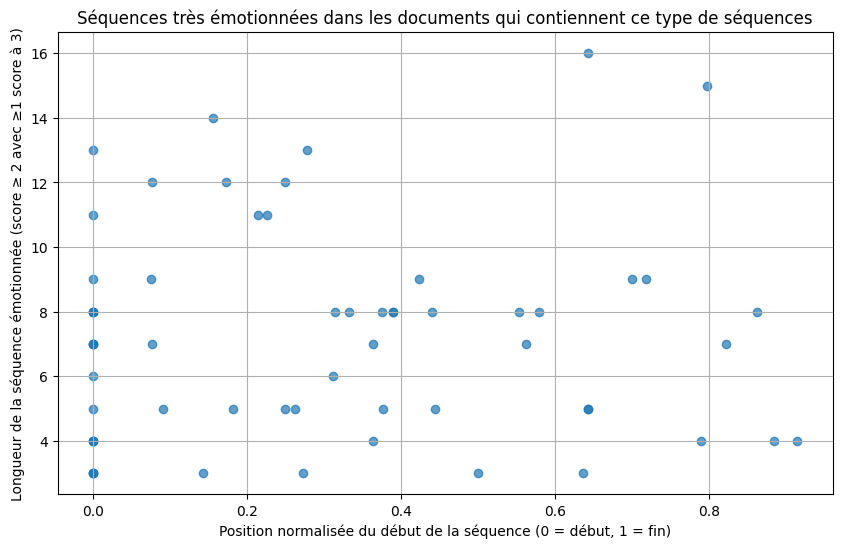

In [55]:
resultats = []

for title, group in mon_fichier.groupby("title"):
    scores = group["score_vf"].tolist()
    n = len(scores)
    if n == 0:
        continue

    scores = np.array(scores)

    max_len = 0
    max_start = -1

    i = 0
    while i < n:
        if scores[i] >= 2:
            start = i
            contains_3 = scores[i] == 3
            length = 1
            i += 1

            while i < n and scores[i] >= 2:
                if scores[i] == 3:
                    contains_3 = True
                length += 1
                i += 1

            if contains_3 and length >= 3:
                if length > max_len:
                    max_len = length
                    max_start = start
        else:
            i += 1

    if max_len == 0:
        continue

    start_norm = max_start / n
    end_norm = (max_start + max_len) / n

    resultats.append({
        "title": title,
        "max_sequence_length": max_len,
        "start_norm": start_norm,
        "end_norm": end_norm
    })

df_sequences = pd.DataFrame(resultats)

# 🎨 Visualisation mise à jour
plt.figure(figsize=(10, 6))
plt.scatter(df_sequences["start_norm"], df_sequences["max_sequence_length"], alpha=0.7)
plt.xlabel("Position normalisée du début de la séquence (0 = début, 1 = fin)")
plt.ylabel("Longueur de la séquence émotionnée (score ≥ 2 avec ≥1 score à 3)")
plt.title("Séquences très émotionnées dans les documents qui contiennent ce type de séquences")
plt.grid(True)
plt.show()

**6. Carte de chaleur montrant la combinaison des scores :**

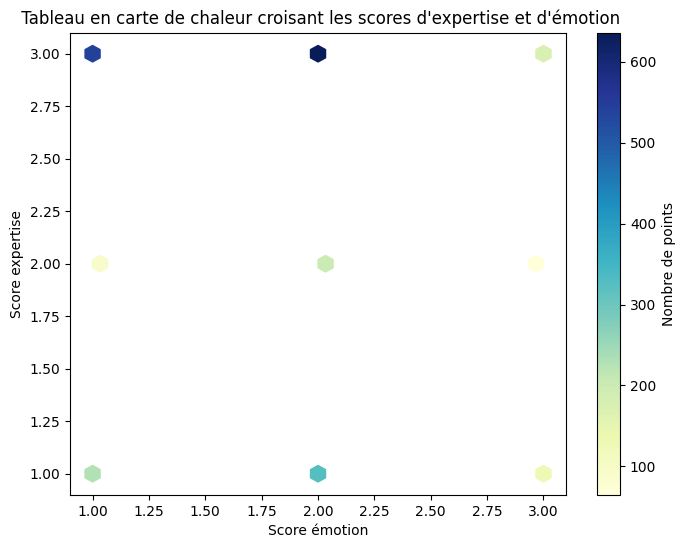

In [32]:
plt.figure(figsize=(8,6))
plt.hexbin(mon_fichier['score_vf'], mon_fichier['expertise_gpt4'], gridsize=30, cmap='YlGnBu', mincnt=1)
plt.colorbar(label='Nombre de points')
plt.xlabel('Score émotion')
plt.ylabel('Score expertise')
plt.title(" Tableau en carte de chaleur croisant les scores d'expertise et d'émotion")
plt.show()


## **Pour la partie sur l'analyse de l' émotion :**

**7. On calcule les documents qui contiennent les scores émotionnels les plus hauts :**

In [ ]:
# Seuil : ici, on considère "début" comme les 10% premiers du texte
seuil_debut = 0.2

# Filtrer les documents où la séquence la plus émotionnée commence très tôt
docs_debut = df_sequences[df_sequences["start_norm"] <= seuil_debut]

# Afficher les titres
print("Documents dont le passage le plus émotionné commence en début de discours :")
print(docs_debut[["title", "start_norm", "max_sequence_length"]])


Documents dont le passage le plus émotionné commence en début de discours :
                                                title  start_norm  \
1   CLIMAT_ENQUTE_SUR_UN_MENSONGE_MONDIAL_ALBAN_D_...    0.181818   
2   DME_Maintenant_Ce_Sont_Les_Huitres_Qui_Sont_Re...    0.000000   
6   DME_Maintenant_Votre_Potager_Serait_Le_Respons...    0.142857   
10  DME_Votre_RESPIRATION_Est_Mauvaise_Pour_le_Cli...    0.076923   
12  LE_CLUB_DE_ROME_LE_GROUPE_SECRET_L_ORIGINE_DE_...    0.000000   
17  Tatiana_ventose_LA_PEUR_POUR_NOUS_ FAIRE_ACCEP...    0.172414   
18  Véritable_réchauffement_climatique_ou_prise_de...    0.000000   
19     aberkane_vers_une_dictature_climatique.txt.txt    0.075269   
20      climat_corona_et_caetera_henri_de_lesquen.txt    0.000000   
22             dme_colocation_obligatoire_en_2025.txt    0.000000   
23                        dme_l'empreinte_carbone.txt    0.000000   
27                   fab_roots_controle_du_climat.txt    0.000000   
28              faroukdj71_

## **Pour la partie qui étudie les chevauchements entre expertise et émotion :**

**8. Quels passages montrent deux scores hauts, à 3 ?**

In [56]:
df_score_eleve = mon_fichier[(mon_fichier['score_vf'] == 3) & (mon_fichier['expertise_gpt4'] == 3)]
df_score_eleve

,Unnamed: 0,title,content,score,score_echelle,score_par_label,sum_without_neutral,sum_recalibree,label_dominant,intensite_emotion,score_vf,expertise_gpt4
1,1,climat_corona_et_caetera_henri_de_lesquen.txt,"Le 26 février 2020, le PSG a joué au pied à Ly...",0.684093,2,"sad: 0.1762, fear: 0.0697, anger: 0.6841, neut...",0.9687,7.345752,anger,2,3,3
2,2,climat_corona_et_caetera_henri_de_lesquen.txt,"Le soir même, jeudi 12 mars, sans plus attendr...",0.551490,2,"sad: 0.4262, fear: 0.0081, anger: 0.5515, neut...",0.9901,5.284120,anger,2,3,3
15,15,climat_corona_et_caetera_henri_de_lesquen.txt,"C'est notamment le cas pour les nuages, qui jo...",0.482279,1,"sad: 0.0229, fear: 0.3193, anger: 0.0470, neut...",0.8749,28.279754,surprise,3,3,3
34,34,climat_schwab_crache_le_morceau_florian_philip...,"Professeur agrégé de philosophie, qui est vice...",0.931207,3,"sad: 0.0030, fear: 0.0005, anger: 0.0004, neut...",0.9376,21.849069,joy,3,3,3
39,39,climat_schwab_crache_le_morceau_florian_philip...,"Et si vous venez à deux, inscrivez-vous, s'il ...",0.791400,3,"sad: 0.0042, fear: 0.0007, anger: 0.0010, neut...",0.8011,18.648715,joy,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2310,2310,tocsin_rechauffement_climatique_un_physiscien_...,Mais mes collègues chercheurs n'ont pas le tem...,0.885262,3,"sad: 0.0518, fear: 0.0222, anger: 0.8853, neut...",0.9832,4.833768,anger,2,3,3
2315,2315,toscin_Le_rechauffement_climatique_est_un_nouv...,"Le climat, l'évolution du climat, le changemen...",0.536594,2,"sad: 0.0032, fear: 0.0024, anger: 0.0023, neut...",0.5575,13.070159,joy,2,3,3
2335,2335,toscin_Le_rechauffement_climatique_est_un_nouv...,"Et après, en tout cas, merci d'être là ce mati...",0.862050,3,"sad: 0.0042, fear: 0.0009, anger: 0.0012, neut...",0.8725,20.316180,joy,3,3,3
2373,2373,tvl_benoit_rittaud.txt,Je mentionne dans mon ouvrage un appel qui a é...,0.517273,2,"sad: 0.5173, fear: 0.0207, anger: 0.4191, neut...",0.9666,6.141685,sad,2,3,3


9. **Calculer le pourcentage de segments qui combinent des scores hauts pour les deux dimensions linguistiques étudiées :**

In [47]:
mon_fichier["score_vf"] = pd.to_numeric(mon_fichier["score_vf"], errors="coerce")
mon_fichier["expertise_gpt4"] = pd.to_numeric(mon_fichier["expertise_gpt4"], errors="coerce")

df_both3 = mon_fichier[(mon_fichier["score_vf"] == 3) & (mon_fichier["expertise_gpt4"] == 3)]

# Nombre de segments concernés
nb_both3 = len(df_both3)

# Nombre total de segments
nb_total = len(mon_fichier)

# Pourcentage
pourcentage = (nb_both3 / nb_total) * 100

print(f"Nombre de segments avec émotion=3 et expertise=3 : {nb_both3}")
print(f"Nombre total de segments : {nb_total}")
print(f"Pourcentage : {pourcentage:.2f}%")

Nombre de segments avec émotion=3 et expertise=3 : 176
Nombre total de segments : 2398
Pourcentage : 7.34%


10. **Pour visualiser le nombre de discours qui ne comprennent pas de segment annoté 3 : **

In [49]:
# Grouper par titre et vérifier si au moins un segment a score=3
discours_sans_3 = mon_fichier.groupby("title")["score_vf"].apply(lambda x: (x == 3).sum() == 0)

# Comptage
nb_sans3 = discours_sans_3.sum()  # nb de discours sans aucun 3
nb_total_discours = discours_sans_3.shape[0]

# Pourcentage
pourcentage_sans3 = (nb_sans3 / nb_total_discours) * 100 if nb_total_discours > 0 else 0

print(f"Nombre de discours sans score émotionnel = 3 : {nb_sans3}")
print(f"Nombre total de discours : {nb_total_discours}")
print(f"Pourcentage : {pourcentage_sans3:.2f}%")


Nombre de discours sans score émotionnel = 3 : 38
Nombre total de discours : 115
Pourcentage : 33.04%


11. **Afficher aussi le nombre de discours sans score émotionnel sans 2 ni 3 :**

In [50]:
# Vérifier quels discours ont uniquement des scores émotionnels = 1
discours_tout_1 = mon_fichier.groupby("title")["score_vf"].apply(lambda x: (x.astype(float) == 1).all())

# Extraire les titres
titres_tout_1 = discours_tout_1[discours_tout_1].index.tolist()

print("Titres des discours avec uniquement score émotionnel = 1 :")
for t in titres_tout_1:
    print("-", t)

print(f"\nNombre de discours avec uniquement score émotionnel = 1 : {len(titres_tout_1)}")


Titres des discours avec uniquement score émotionnel = 1 :
- dme_en_direct_L'ecologie_la_Plus_Grande_Arnaque_du_Siècle.txt
- on_nous_aurait_menti_sur_le_co2_hacine_dz.txt

Nombre de discours avec uniquement score émotionnel = 1 : 2
